# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Pipeline Building](#Pipeline-Building)
- [Bagging](#Bagging)
- [Boosting](#Boosting)
- [Testing](#Testing)
- [Original Scale predictions](#Original-scale-predictions)
- [Results](#Results)
- [Conclusion](#Conclusion)

## Introduction
### Regression Analysis: Day 6 - Ensembling
- This notebook focuses on Ensembling techniques to improve model Stability.

## Importing Libraries

In [162]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [163]:
train_data = pd.read_csv("train_errorAnalysed.csv")
test_data = pd.read_csv("test_errorAnalysed.csv")
train_data.shape,test_data.shape

((138, 14), (62, 14))

## Pipeline Building

In [164]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,FunctionTransformer
from sklearn.model_selection import cross_val_predict,cross_validate,RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm
from sklearn.ensemble import BaggingRegressor

X_train=train_data.drop(columns=['price',"car_ID"])
y_train=train_data['price']
X_test=test_data.drop(columns=['price',"car_ID"])
y_test=test_data['price']

def to_dataframe(X):
    if isinstance(X, np.ndarray):
        return pd.DataFrame(X, columns=cat_cols + num_cols)
    return X

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop(columns=["car_ID","price"]).columns if train_data[col].dtype!= pl.String]

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")

ridge_pipe = Pipeline([
    ('to_dataframe', FunctionTransformer(to_dataframe)),
    ('imputer', imputer),
    ("ridge",Ridge(alpha=0.505))
])
ridge_pipe

Pipeline(steps=[('to_dataframe',
                 FunctionTransformer(func=<function to_dataframe at 0x0000028D4D3F5430>)),
                ('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=9),
                                                  ['aspiration', 'carbody',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['carclass', 'brandavg',
                                                   'carspace', 'averagempg',
                                                   'performancebalance',
                                                   'enginedisplacement',
                                                   'curbweight',
                                                   'horsepower'])])),
                ('ridge', Ridge(alpha=0.505))])

## Bagging

Mean Train Score: 0.9440773172316749
Standard Deviation of Train Scores: 0.0032238518278198762
Mean Test Score: 0.9072453219349363
Standard Deviation of Test Scores: 0.05100766596054272
Mean absolute Error: 0.053940019963636746
R-squared on holdout set: 0.8810793830345954
Adjusted R-squared on holdout set: 0.8519559666349046


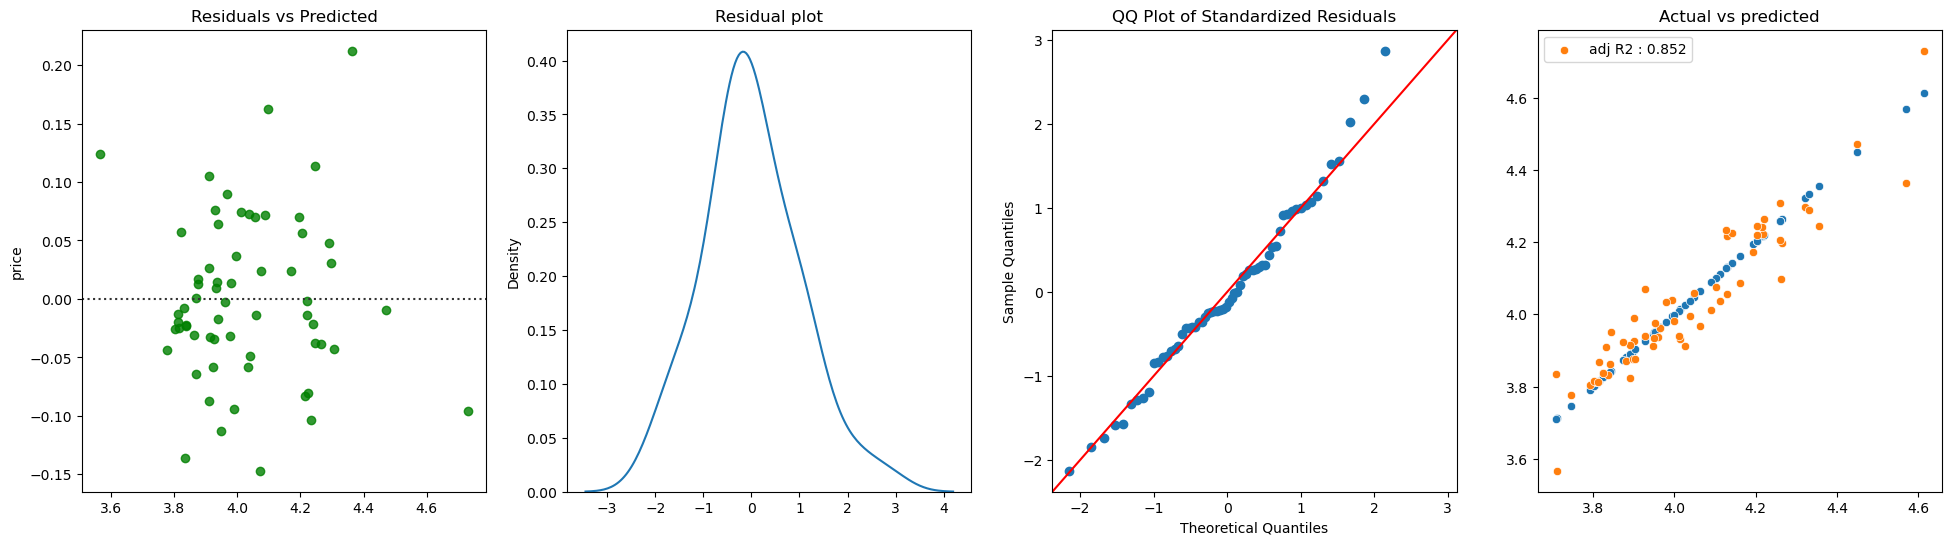

In [165]:
bagging_regressor = BaggingRegressor(
    base_estimator=ridge_pipe,
    n_estimators=120,
    random_state=42,
    n_jobs=-1)
# # Define the cross-validation strategy
rkf = RepeatedKFold(n_splits=10, random_state=42)

cv_results = cross_validate(bagging_regressor, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(bagging_regressor, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
ax4.set_title("Actual vs predicted")
ax4.set_xlabel("")
ax4.set_ylabel("")
plt.show()

## Boosting

Mean Train Score: 0.9460570044045657
Standard Deviation of Train Scores: 0.0038138746860722607
Mean Test Score: 0.9076523045421782
Standard Deviation of Test Scores: 0.05390794029954431
Mean absolute Error: 0.053940019963636746
R-squared on holdout set: 0.8810793830345954
Adjusted R-squared on holdout set: 0.8519559666349046


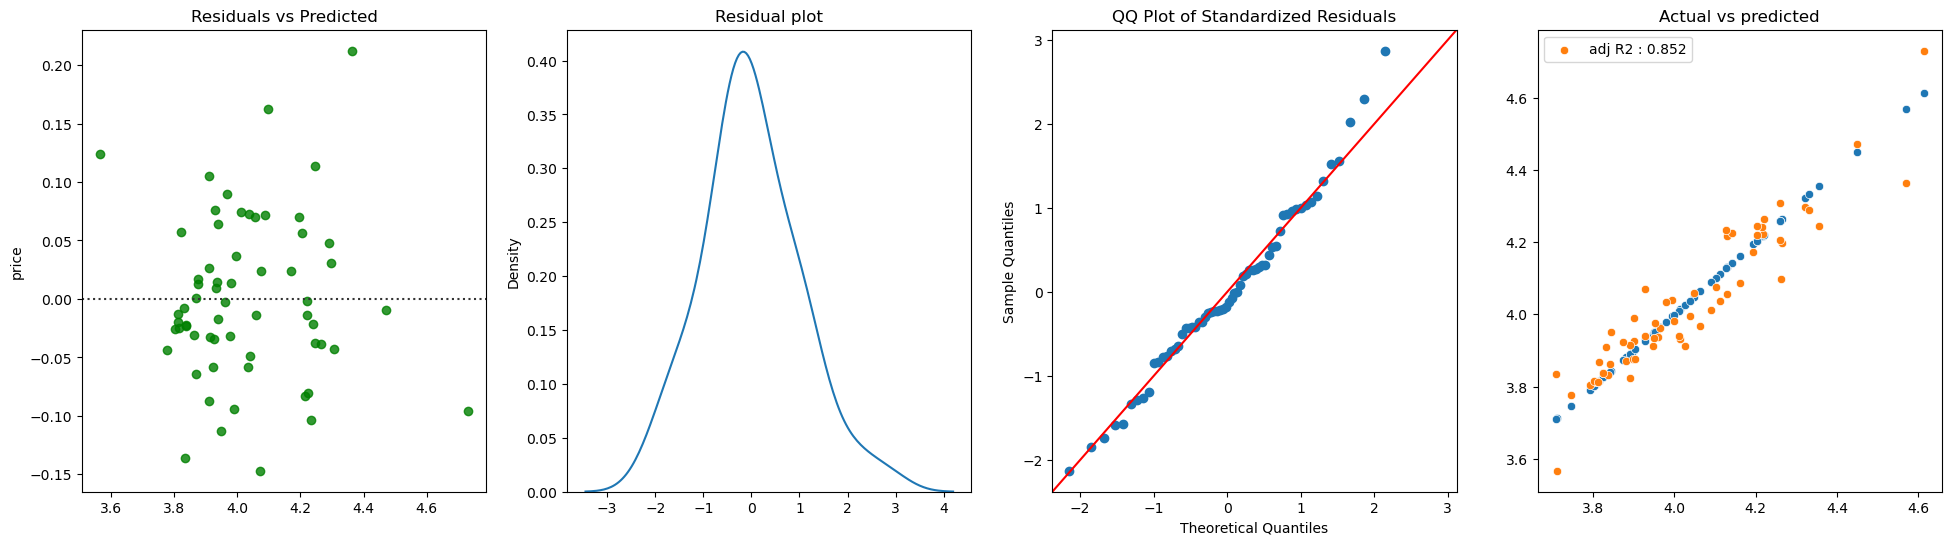

In [166]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline with elastic Regressor
elastic_pipe = Pipeline([
    ("pandas",FunctionTransformer(to_dataframe)),
    ('imputer', imputer),
    ('Ridge', Ridge(alpha=0.505))
])

# Wrap the pipeline in an AdaBoost Regressor
boosting_elastic = AdaBoostRegressor(estimator=elastic_pipe, n_estimators=100, random_state=42)

# Train the model
boosting_elastic.fit(X_train, y_train)

# Predict and evaluate
cv_results = cross_validate(boosting_elastic, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(bagging_regressor, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
ax4.set_title("Actual vs predicted")
ax4.set_xlabel("")
ax4.set_ylabel("")
plt.show()

Both Bagging and boosting Same Scores which are little lesser than actual model.Our base estimator looks Strong enough

## Testing

In [167]:
transform_pipe = Pipeline([
    ('imputer', imputer)
])
# Fit the transformation pipeline on the training data
X_train_transformed=transform_pipe.fit_transform(X_train)

# Transform the test data
X_test_transformed = transform_pipe.transform(X_test)
X_test_transformed.shape

(62, 16)

In [168]:
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera

# X_test_transformed = imputer.transform(X_test)
# X_test_transformed = pd.DataFrame(X_test_transformed, columns=imputer.get_feature_names_out())
# # Add a constant (intercept term)
X_test_transformed = sm.add_constant(X_test_transformed)

# Durbin-Watson test for autocorrelation
dw_test = durbin_watson(residuals)
print(f"Durbin-Watson test statistic: {dw_test}")
# Residuals Normailty check
shapiro_test = shapiro(residuals)  #for small datasets
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
jb_test = jarque_bera(residuals)   
print(f"Jarque-Bera test: Statistic={jb_test[0]}, p-value={jb_test[1]}")
# Breusch-Pagan test for Homoscedastic residuals
bp_test = het_breuschpagan(residuals, X_test_transformed)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))
# Multi-collinearity
def condition_index(X):
  if not np.all(X.shape[1] >= 2):
    raise ValueError("Input matrix must have at least two columns.")
  return np.linalg.cond(X)

condition_number = condition_index(transform_pipe.transform(X_train))
print(f"Condition number: {condition_number:.4f}")

Durbin-Watson test statistic: 1.838646880894546
Shapiro-Wilk test: Statistic=0.983599066734314, p-value=0.5758170485496521
Jarque-Bera test: Statistic=1.464336605234251, p-value=0.4808651976037158
{'Lagrange multiplier statistic': 22.060375467284103, 'p-value': 0.14125277422862126, 'f-value': 1.553464929318841, 'f p-value': 0.12295917544141557}
Condition number: 17.9093


All test passed.

## Original Scale Predictions
(Not for evaluation as Dependent variable is skewed)

Mean Absolute Error in Original Scale (Unbiased): 1652.6842239795299
Mean Absolute Error in Original Scale (biased): 1330.7239556878683


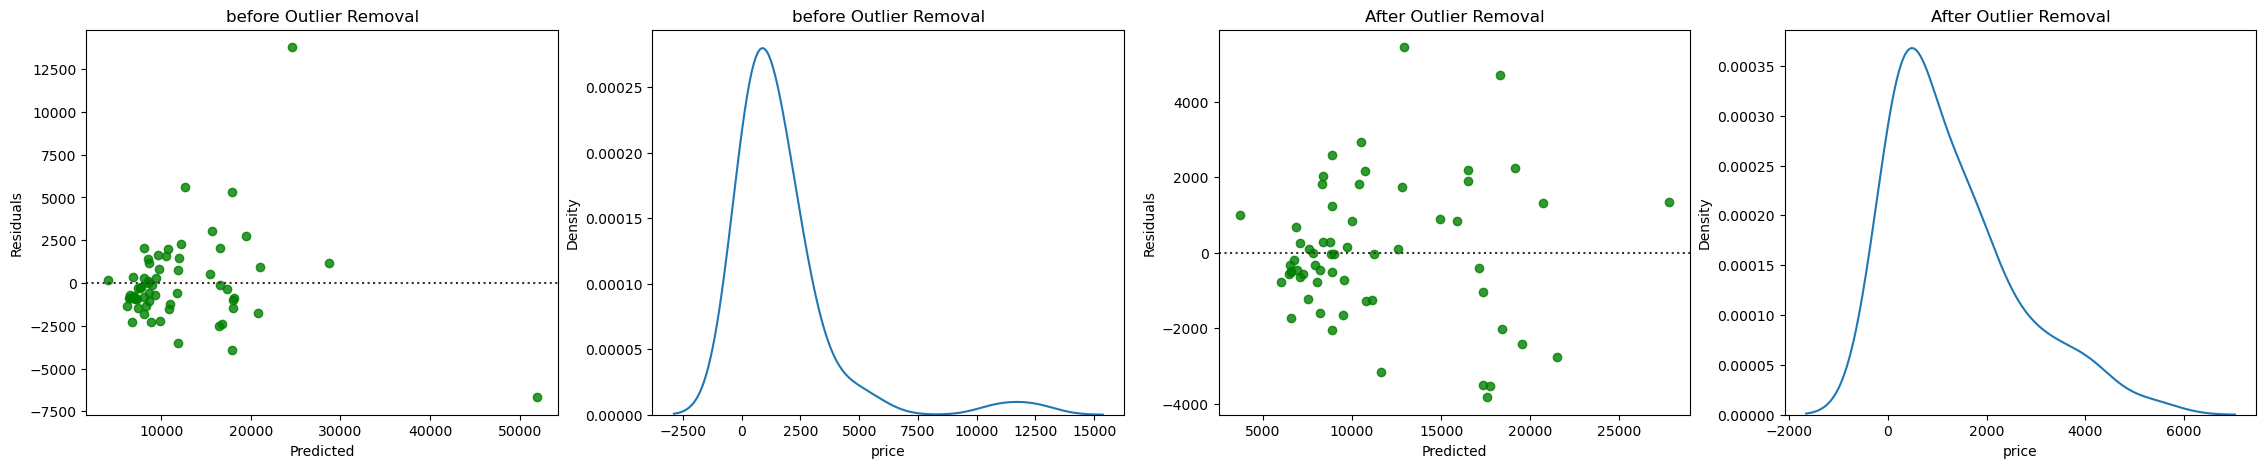

In [169]:
predictions = cross_val_predict(elastic_pipe, X_test, y_test)
residuals = y_test - predictions
# Sample data (assuming y_test and predictions are in log10 scale)
y_test_transformed = y_test
predictions_transformed = predictions

# Convert predictions back to original scale
y_test_original = 10**y_test_transformed
predictions_original = 10**predictions_transformed

# Calculate the absolute error in the original scale
residuals_original = np.abs(y_test_original - predictions_original)

# Calculate mean absolute error in the original scale
mae_original = np.mean(residuals_original)

# Outliers
X_test_after=X_test[~X_test.index.isin([22,35])]
y_test_after=y_test[~y_test.index.isin([22,35])]

predictions_after = cross_val_predict(elastic_pipe, X_test_after, y_test_after)
residuals_original_after = y_test_after - predictions_after
# Sample data (assuming y_test and predictions are in log10 scale)
y_test_transformed_after = y_test_after
predictions_transformed_after = predictions_after

# Convert predictions back to original scale
y_test_original_after = 10**y_test_transformed_after
predictions_original_after = 10**predictions_transformed_after

# Calculate the absolute error in the original scale
residuals_original_after = np.abs(y_test_original_after - predictions_original_after)

# Calculate mean absolute error in the original scale
mae_original_after = np.mean(residuals_original_after)
print("Mean Absolute Error in Original Scale (Unbiased):", mae_original)
print("Mean Absolute Error in Original Scale (biased):", mae_original_after)
fig,[ax1,ax2,ax3,ax4]=plt.subplots(ncols=4,figsize=(28,5))
sns.residplot(x=predictions_original, y=y_test_original, color='g',ax=ax1)
ax1.set_title("before Outlier Removal")
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
sns.kdeplot(residuals_original,ax=ax2)
ax2.set_title("before Outlier Removal")
sns.residplot(x=predictions_original_after, y=y_test_original_after, color='g',ax=ax3)
ax3.set_title("After Outlier Removal")
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Residuals')
sns.kdeplot(residuals_original_after,ax=ax4)
ax4.set_title("After Outlier Removal")
plt.show()

Performance significantly increased after removing 2 data points.either we are not having information to cover those variance or they could be potential outliers

## Results
### Model Performance Summary (Day 6)

#### Bagging Results
- **Mean Train Score**: 0.9441
- **Standard Deviation of Train Scores**: 0.0032
- **Mean Test Score**: 0.9072
- **Standard Deviation of Test Scores**: 0.0510
- **Mean Absolute Error (MAE)**: 0.0539
- **R-squared (R²)** on Holdout Set: 0.8811
- **Adjusted R-squared** on Holdout Set: 0.8520

#### Boosting Results
- **Mean Train Score**: 0.9461
- **Standard Deviation of Train Scores**: 0.0038
- **Mean Test Score**: 0.9077
- **Standard Deviation of Test Scores**: 0.0539
- **Mean Absolute Error (MAE)**: 0.0539
- **R-squared (R²)** on Holdout Set: 0.8811
- **Adjusted R-squared** on Holdout Set: 0.8520

#### Statistical Tests and Diagnostics
- **Durbin-Watson Test**: The Durbin-Watson statistic is 1.8386, indicating no significant autocorrelation in the residuals.
- **Shapiro-Wilk Test**: The Shapiro-Wilk test statistic is 0.9836 with a p-value of 0.5758, suggesting that the residuals are normally distributed.
- **Jarque-Bera Test**: The Jarque-Bera test statistic is 1.4643 with a p-value of 0.4809, indicating that the residuals have skewness and kurtosis close to those of a normal distribution.
- **Breusch-Pagan Test**: The Lagrange multiplier statistic is 22.0604 with a p-value of 0.1413, suggesting no significant heteroscedasticity.
- **Condition Number**: The condition number remains at 17.9093, indicating some multicollinearity but within acceptable bounds.

#### Error Analysis
- **Mean Absolute Error in Original Scale (Unbiased)**: 1652.6842
- **Mean Absolute Error in Original Scale (Biased)**: 1330.7240

### Insights and Comparison with Previous Days
- Both bagging and boosting techniques have produced similar performance metrics, indicating robustness in model performance.
- The models exhibit high R² values on the holdout set, indicating strong explanatory power.
- The error analysis shows that the mean absolute error in the original scale is lower after inverse transformation, indicating effective modeling even on the original scale.
- Statistical tests and diagnostics suggest that the models meet the assumptions of linear regression, with no significant issues detected in terms of autocorrelation, normality of residuals, or heteroscedasticity.

## Conclusion
- On Day 6, both bagging and boosting techniques have demonstrated excellent performance with high test scores, low mean absolute error, and strong explanatory power. The statistical tests and diagnostics confirm that the models meet the assumptions of linear regression.